In [28]:
import sys
import os
import re
import psycopg2 # don't need to worry about the warning\
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [29]:
# let's get connected
try:
    conn = psycopg2.connect("dbname='litindex' user='python' host='3.16.15.91' password='python'")
except:
    print("Connection failed")

In [30]:
# create a cursor
cur = conn.cursor()

In [31]:
# Let's look at the college distribution
cur.execute("SELECT grid_name, COUNT(*) FROM syllabus GROUP BY grid_name")
rows = cur.fetchall()

In [32]:
print(len(rows))

1


In [33]:
# OK, seems like we have only one college to worry about. Which one?
print(rows)

[('College of New Jersey', 352)]


In [34]:
# We're looking at 352 unique records for the College of New Jersey. Our analysis will be very non-representative, but it's a start
# Next, let's look the distribution of departments
cur.execute("SELECT field_name, COUNT(*) FROM syllabus GROUP BY field_name")
rows = cur.fetchall()

In [35]:
print(len(rows))

14


In [36]:
print(rows)

[('History.', 11), ('Biological and Biomedical Sciences, General/Other.', 11), ('Computer and Information Sciences.', 35), ('Political Science, Government, International Relations and National Security Studies.', 20), ('Psychology, General/Other.', 13), ('Mathematics/Applied Mathematics', 51), ('English Language and Literature/Letters', 83), ('Physics.', 11), ('Fine and Studio Arts.', 13), ('Religion/Religious Studies.', 13), ('Business, Management, and Related Support Services.', 55), ('Economics.', 12), ('Linguistics.', 13), ('Philosophy.', 11)]


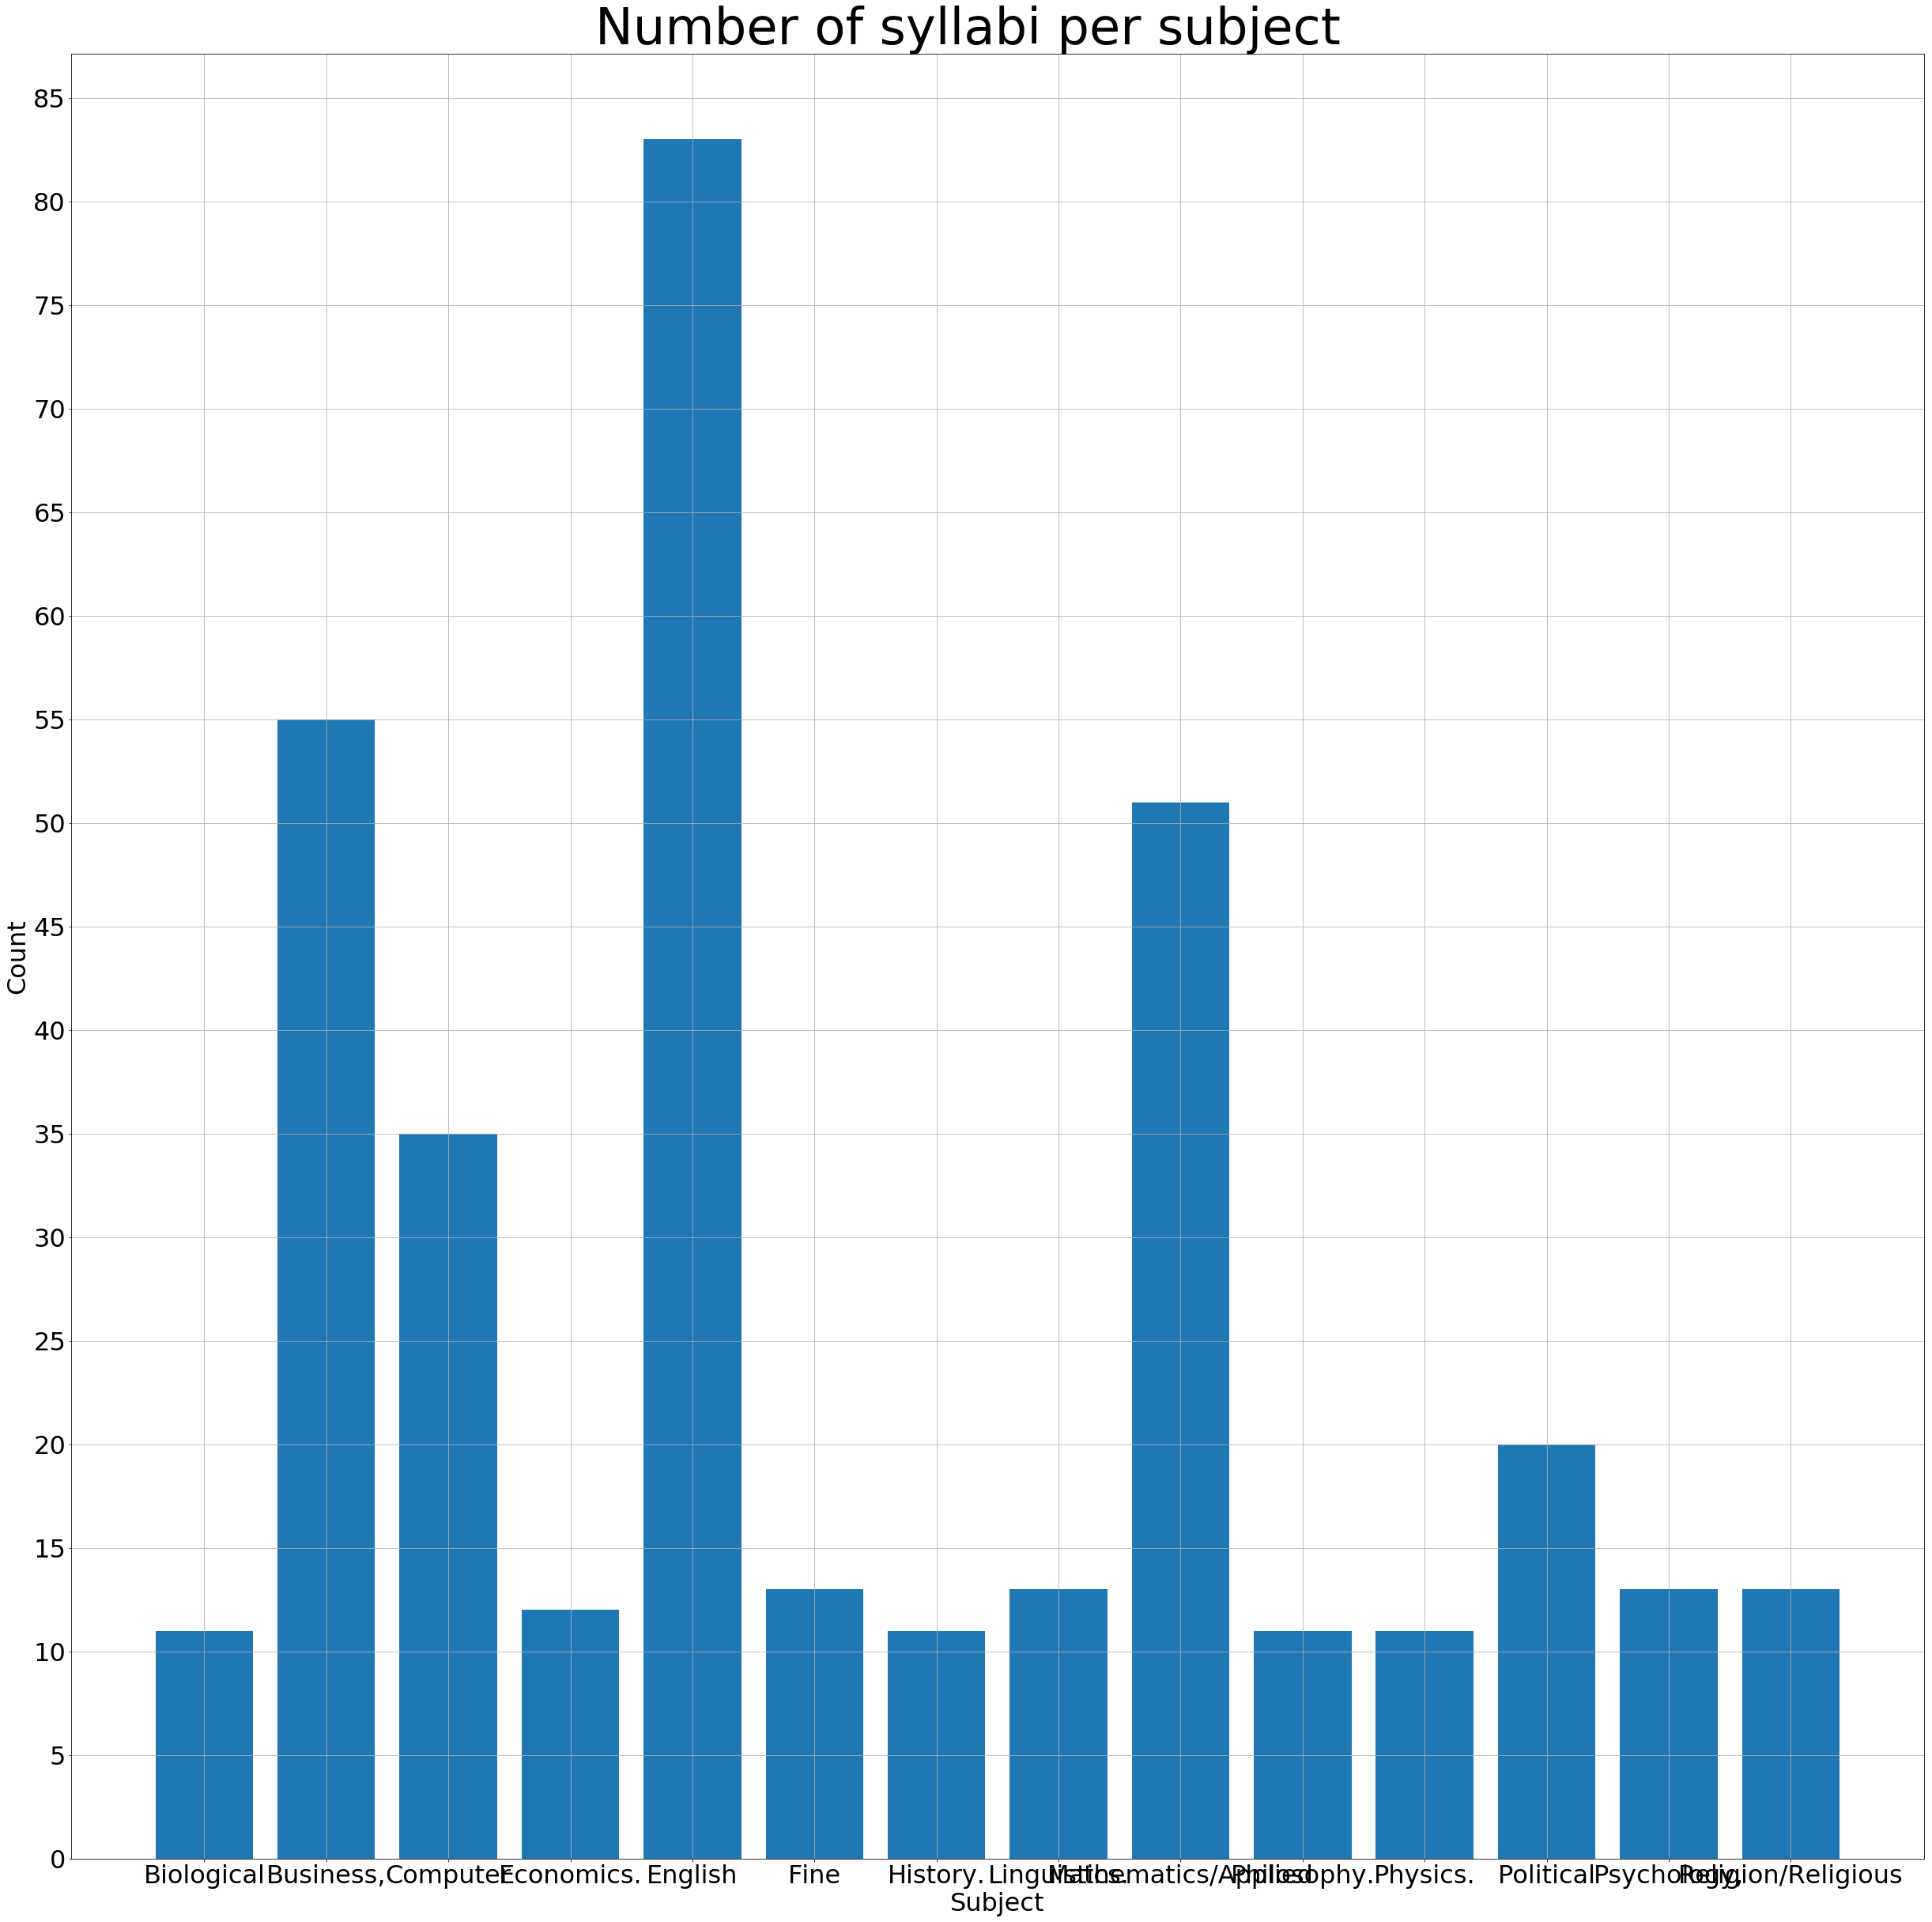

In [37]:
# Those are some long names!!! Thankfully, the first word of each subject is different. Let's just use that as an identifier
# We'll be using bar charts in Matplotlib to plot the distribution of syllabi count in each department
subjects = [x[0].split(' ')[0] for x in rows]
counts = [y[1] for y in rows]

_ = plt.figure(figsize=(42, 42))
_ = plt.bar(subjects, counts)
_ = plt.xlabel('Subject', fontsize=32)
_ = plt.ylabel('Count', fontsize=32)
_ = plt.tick_params(axis='both', which='major', labelsize=32)
_ = plt.tick_params(axis='both', which='minor', labelsize=32)
_ = plt.yticks(np.arange(0, 90, 5))
_ = plt.suptitle("Number of syllabi per subject", fontsize=64, y = .9)
_ = plt.grid()

In [38]:
# As we can see, there's a major imbalance in the number of syllabi per department
# We'll need to factor this into our computation for our "office hours" measurement
# Instead of a simple count, let's use the average number of times office hours appears per syllabi per department
# Let's call this metric "Avg OH Per Department", or AOHPD

# Let's do this computation now
cur.execute("SELECT DISTINCT(field_name) FROM syllabus")
subjects = cur.fetchall()
aohpd = {x[0]: 0 for x in subjects}

cur.execute("SELECT content, field_name FROM syllabus")
for row in cur: # iterate one by one this time, memory constraints (really long syllabi!)
    num_oh_matches = re.findall(r'([Oo]ffice\W+[Hh]ours)', row[0])
    # num_oh_matches = re.findall(r'([Oo]ffice\W+[Hh]ours|OH)', row[0]) # if you wanted to include 'OH' too
    aohpd[row[1]] += len(num_oh_matches)

# now get the number of syllabi in a field
cur.execute("SELECT field_name, count(*) AS per_field FROM syllabus GROUP BY field_name")
for row in cur:
    aohpd[row[0]] /= row[1]

print(aohpd)

{'History.': 0.6363636363636364, 'Biological and Biomedical Sciences, General/Other.': 0.7272727272727273, 'Computer and Information Sciences.': 0.8857142857142857, 'Political Science, Government, International Relations and National Security Studies.': 0.6, 'Psychology, General/Other.': 0.38461538461538464, 'Mathematics/Applied Mathematics': 0.49019607843137253, 'English Language and Literature/Letters': 0.7228915662650602, 'Physics.': 0.09090909090909091, 'Fine and Studio Arts.': 0.9230769230769231, 'Religion/Religious Studies.': 1.2307692307692308, 'Business, Management, and Related Support Services.': 1.0727272727272728, 'Economics.': 1.0833333333333333, 'Linguistics.': 0.9230769230769231, 'Philosophy.': 0.7272727272727273}


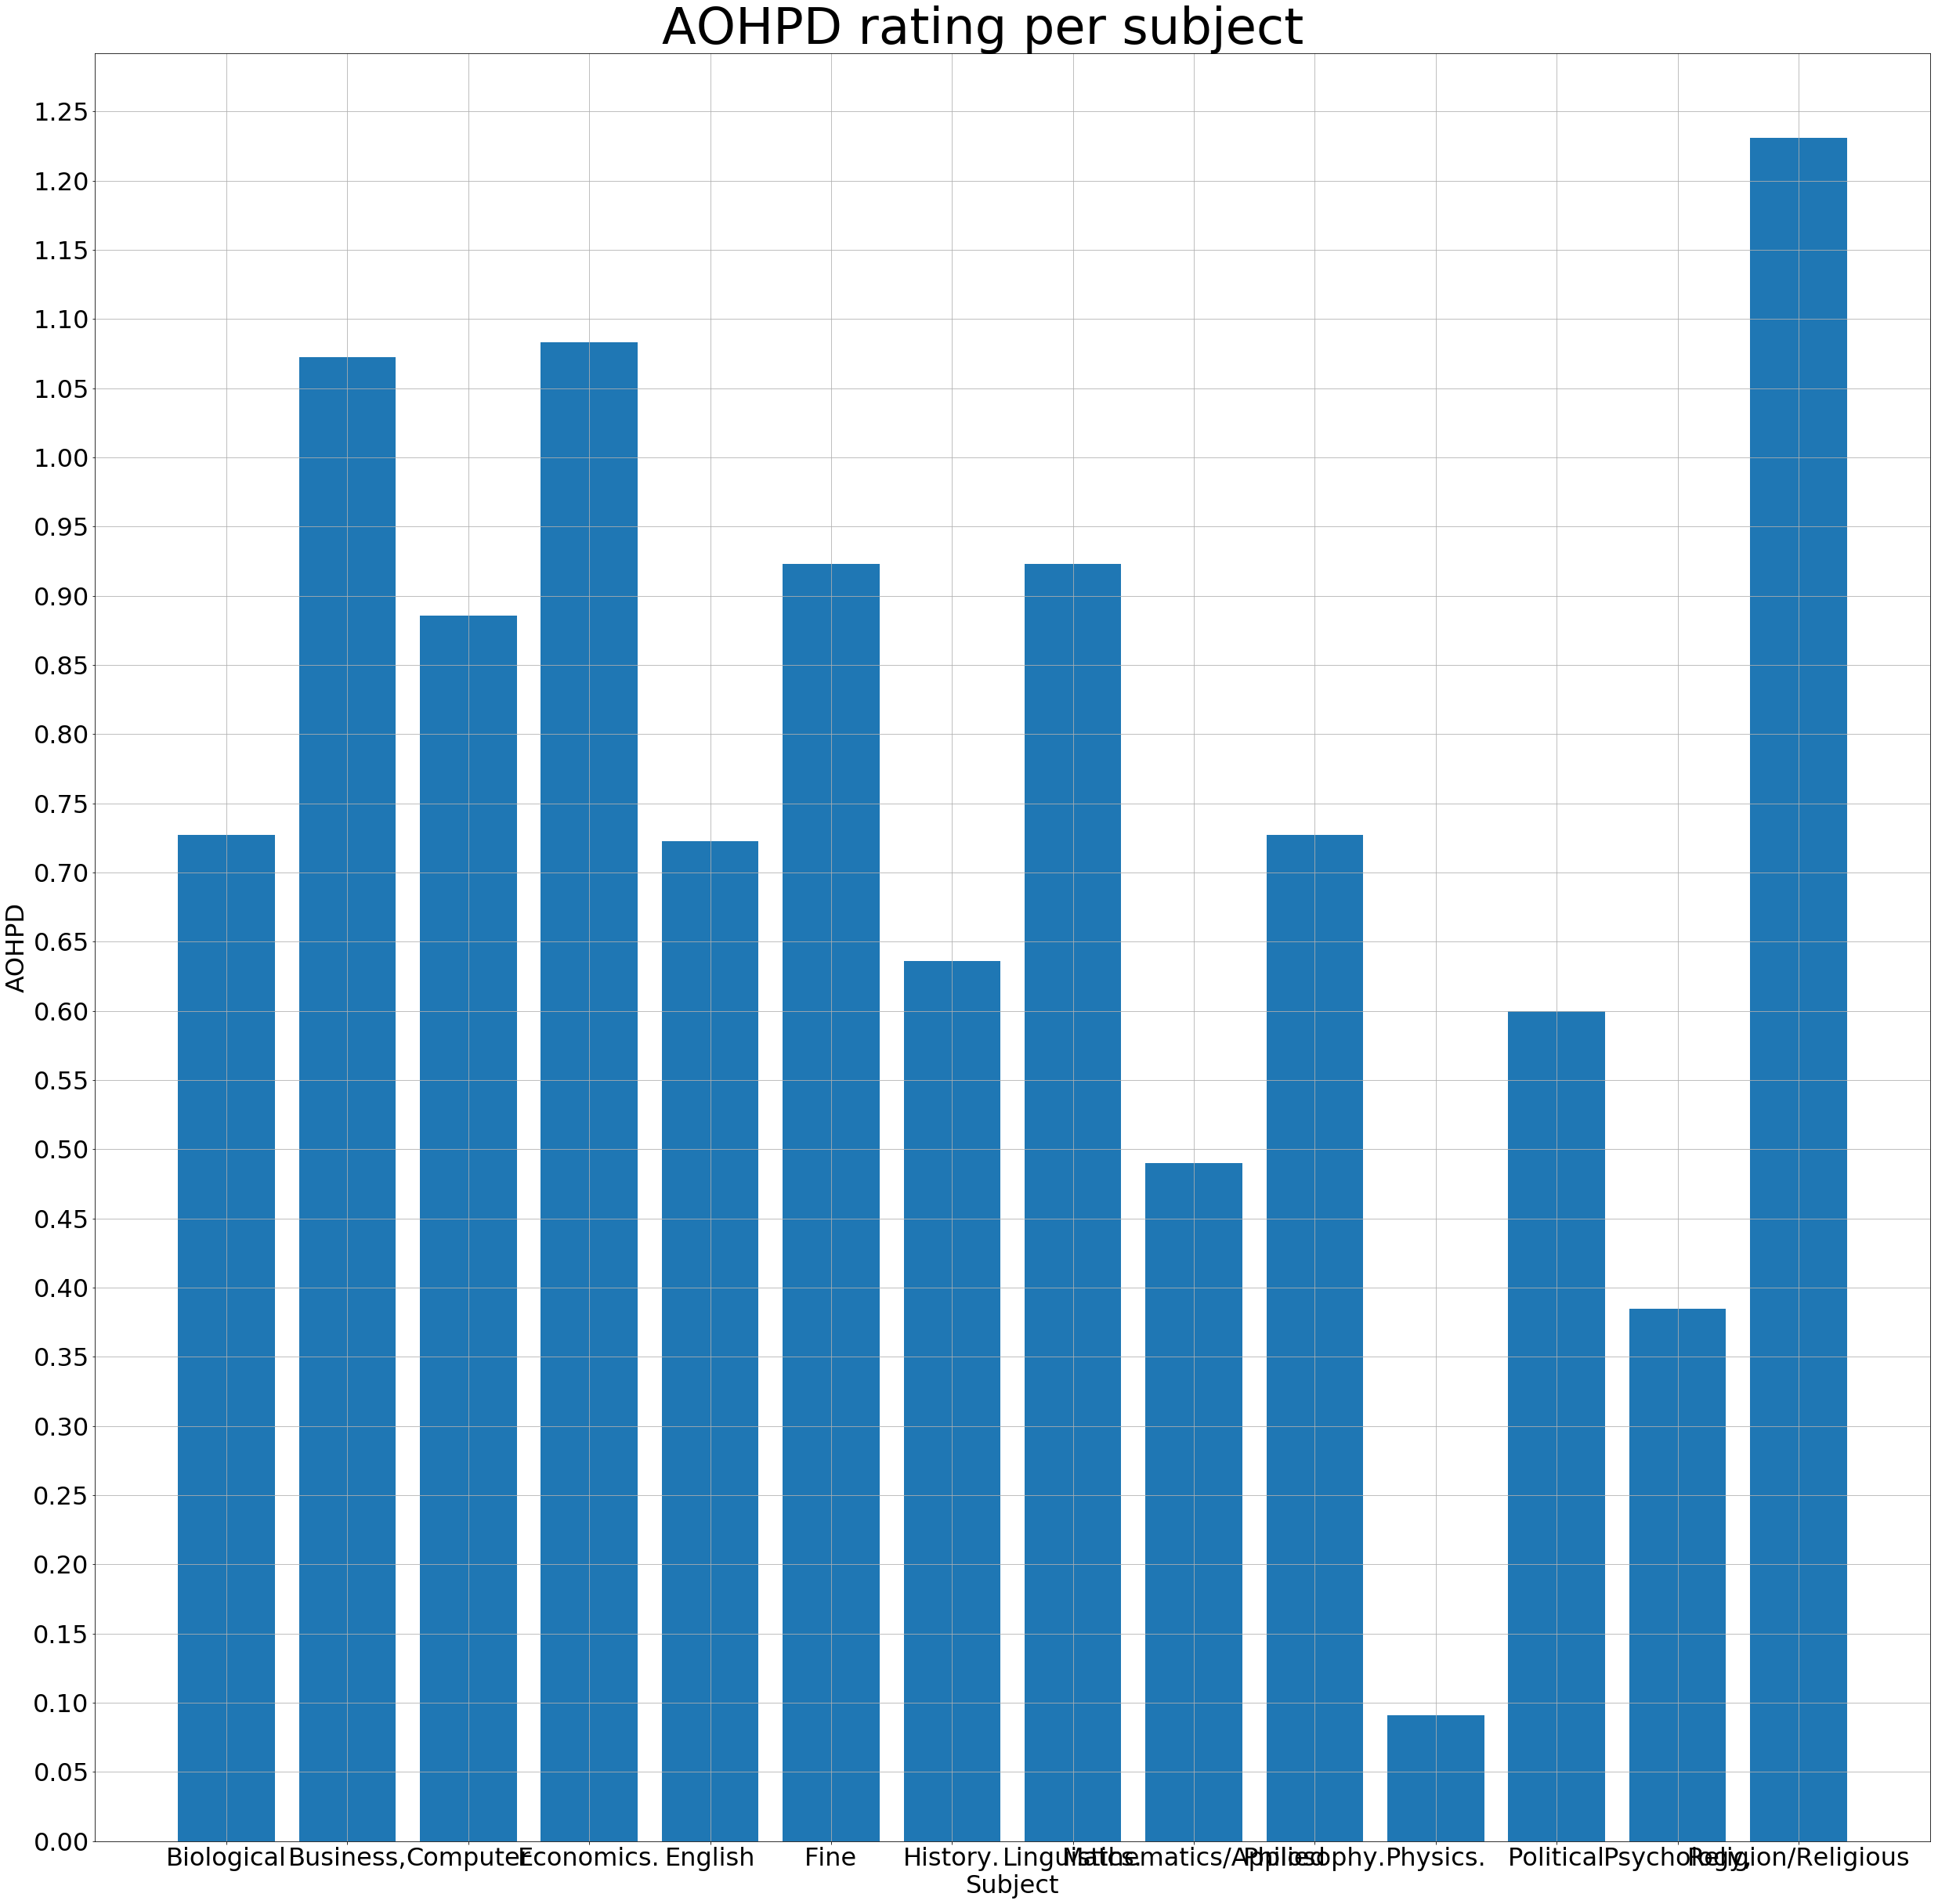

In [39]:
# from a first glance, it seems like the term "office hours" is lacking...
# let's visualize this on a bar chart

domains = [x.split(' ')[0] for x in aohpd.keys()]
aohpd_values = [aohpd[y] for y in aohpd]

_ = plt.figure(figsize=(42, 42))
_ = plt.bar(domains, aohpd_values)
_ = plt.xlabel('Subject', fontsize=32)
_ = plt.ylabel('AOHPD', fontsize=32)
_ = plt.tick_params(axis='both', which='major', labelsize=32)
_ = plt.tick_params(axis='both', which='minor', labelsize=32)
_ = plt.yticks(np.arange(0, 1.3, .05))
_ = plt.suptitle("AOHPD rating per subject", fontsize=64, y = .9)
_ = plt.grid()

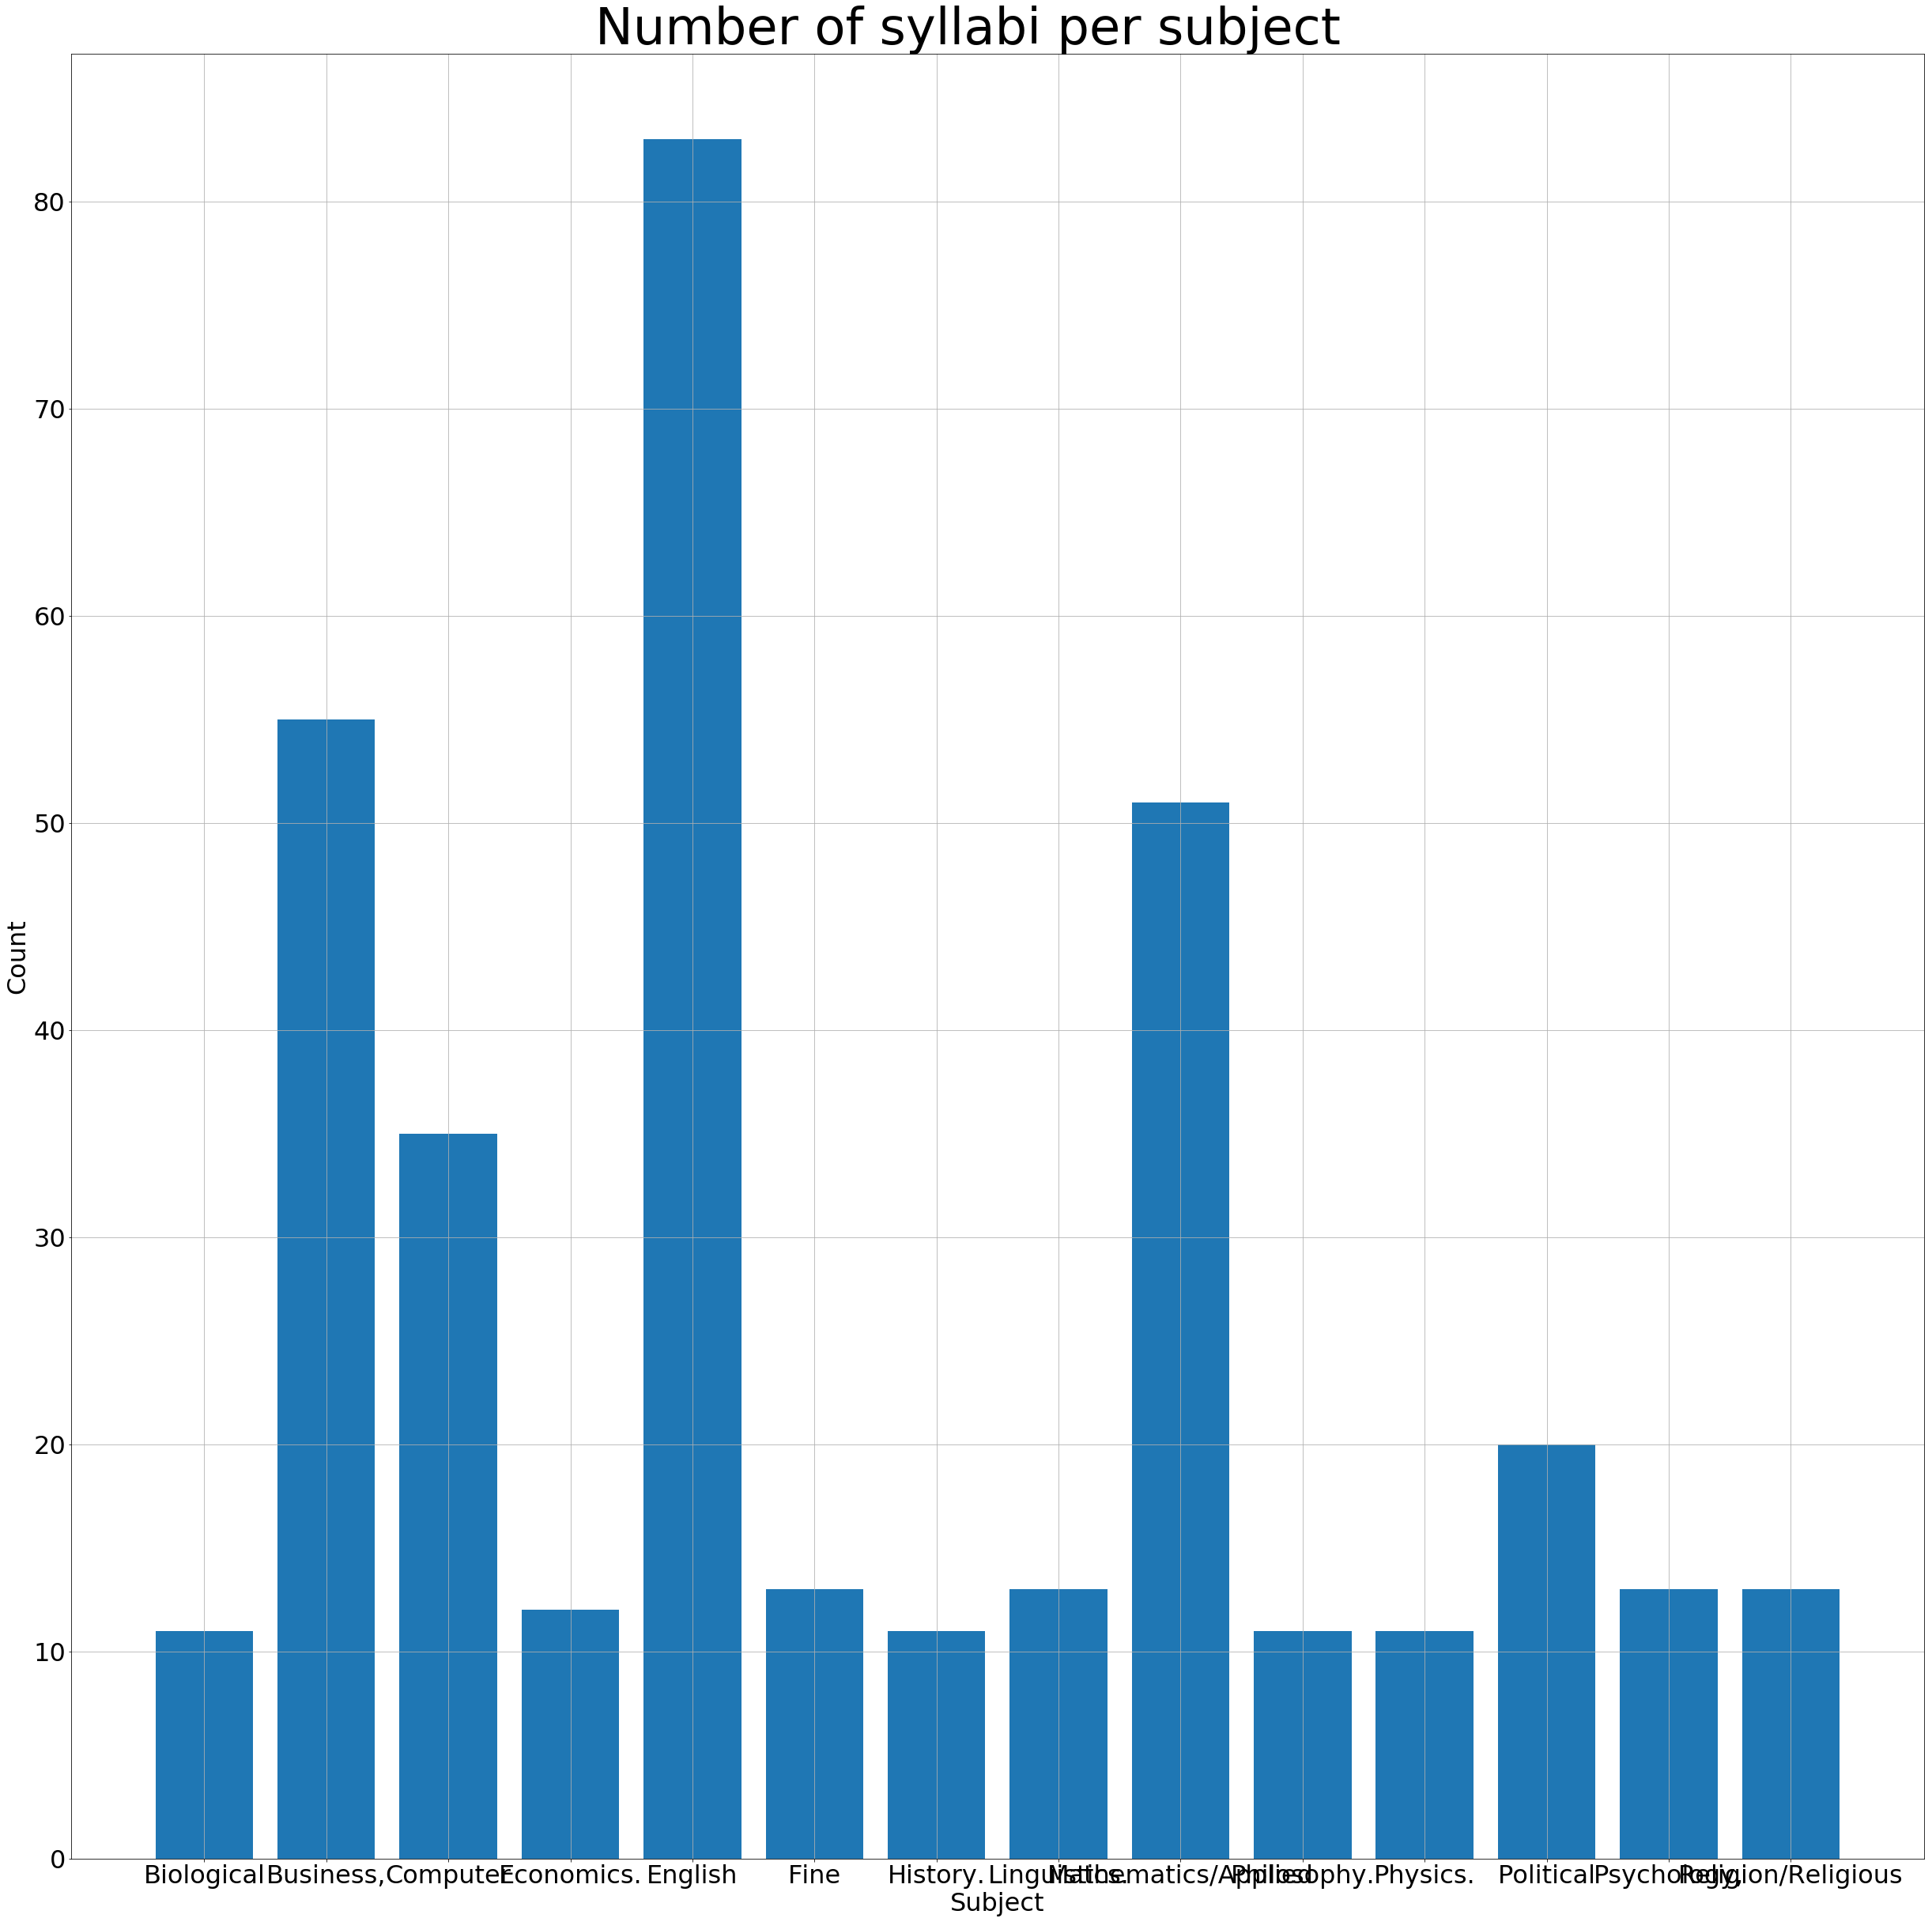

In [40]:
# let's reiterate the subject counts graph for comparison
subjects = [x[0].split(' ')[0] for x in rows]
counts = [y[1] for y in rows]

_ = plt.figure(figsize=(42, 42))
_ = plt.bar(subjects, counts)
_ = plt.xlabel('Subject', fontsize=32)
_ = plt.ylabel('Count', fontsize=32)
_ = plt.tick_params(axis='both', which='major', labelsize=32)
_ = plt.tick_params(axis='both', which='minor', labelsize=32)
_ = plt.suptitle("Number of syllabi per subject", fontsize=64, y = .9)
_ = plt.grid()

In [41]:
# From here, we can see that the AOHPD rating is quite disparate over the different subjects
# Additionally, there doesn't seem to be a correlation between AOHPD rating and number of syllabi per subject
# This doesn't necessarily rule out all bias, however, as one document could contain an anomalous number of "office hours"
# Nevertheless, it seems less likely that sample size will be a bias

# It's kind of funny to see Religion/Religious Studies at the top, and Physics at the bottom
# But this information alone warrants more research into why certain subjects seem to have lower AOHPD ratings

In [42]:
conn.close()